In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
import time
import timeit
import warnings
warnings.filterwarnings('ignore')
global_params = {
    'text.usetex' : False,
    'font.family' : 'serif',
    'font.sans-serif' : ['Helvetica'],
    'ps.usedistiller' : 'xpdf',
    'ps.distiller.res' : 3000,
    'axes.labelsize' : 13,
          #'text.fontsize' : 16,
    'legend.fontsize' : 10,
    'xtick.labelsize' : 12,
    'ytick.labelsize' : 12,
    'axes.linewidth': 2.0,
    'axes.grid':True,  
    'figure.figsize' : [7,5],
    'grid.linestyle':'--',
    'grid.color':'k',
    'grid.alpha':0.2}
pylab.rcParams.update(global_params)
#use env ../speedPy.yml
rng = np.random.default_rng()

## Doing Math By Hand Is Important
In this notebook I will show with an example why doing math by hand is important for making your code go fast
### Example
For this example we will be drawing from a multivariate normal with many dimensions. Our covariance matrix has a specific form which we will be exploiting for speed ups later.

Our covariance matrix looks like
$$
\sigma=\begin{bmatrix} 
a_{0} & 0     & \cdots & 0      & c_{0}  & 0     &\cdots &0     \\
0     & a_{1} & \ddots &        & \ddots & c_{1} & \ddots&\vdots\\
\vdots&\ddots & \ddots & \ddots &        &\ddots &\ddots &\vdots\\
0     &       &  \ddots& a_{n}  &  \ddots&       &\ddots & c_{n}\\
c_{0} & 0     &\cdots &0        &b_{0}   & 0     & \cdots& 0    \\   
0     & c_{1} & \ddots &        & \ddots & b_{1} & \ddots&\vdots\\
\vdots&\ddots & \ddots & \ddots &        &\ddots &\ddots &\vdots\\
0     &\cdots &  0     & c_{n}  &  0     & \cdots&0      & b_{n}
\end{bmatrix}
$$

or more clearly

$$
\sigma=\begin{bmatrix}
A & C\\
C & B
\end{bmatrix}
$$
where $A,B$ and $C$ are $nxn$ diagnal matricies with elements $A_{ii}=a_i$ and so on.

We have our problem so now we construct our matrix and draw from it.

In [9]:
def large_cov_mvn(a,b,c,seed=42,method='svd'):
    rng = np.random.default_rng(seed=seed)
    #draw a sample using a large cov matrix
    dim=2*len(a)
    #first construct the matrix
    cov=np.zeros((dim,dim))
    for i in range(len(a)):
        cov[i][i]=a[i]
        cov[i+dim//2][i+dim//2]=b[i]
        cov[i+dim//2][i]=c[i]
        cov[i][i+dim//2]=c[i]
    return rng.multivariate_normal(mean=np.zeros(dim),cov=cov,method=method)
n=10
a=rng.uniform(.1,10,n)
b=rng.uniform(.1,10,n)
c=rng.uniform(.1,10,n)
large_cov_mvn(a,b,c)

array([ 3.25839985, -1.39864599,  0.02120036, -0.10477266, -0.22223753,
       -4.05609504,  1.74988619,  2.46030639,  1.57855097, -1.59884985,
        6.10738347, -0.02908533, -1.48627997,  0.59820767, -0.32622501,
       -0.42360347,  4.49613851, -0.82092406,  4.18679184, -2.10577886])

Great! problem solved ... however this ends up being too slow as you increase the size of n.

In [23]:
N=np.arange(10,1000,25)
large_cov_times=[]
for n in N:
    setup=f'a,b,c=rng.uniform(.1,10,{n}),rng.uniform(.1,10,{n}),rng.uniform(.1,10,{n})'
    t=timeit.Timer('large_cov_mvn(a,b,c)',globals=globals(),setup=setup).repeat(3,1)
    large_cov_times.append([np.mean(t),np.std(t)])
large_cov_times=np.array(large_cov_times)

In [ ]:
from scipy.optimize import curve_fit
def lin(x,a):
    return x*a
def quad(x,a,b):
    return a*x+b*x**2
def cube(x,a,b,c):
    return a*x+b*x**2+c*x**3
cubic_fit_large_cov=curve_fit(cube,N,large_cov_times[:,0],sigma=large_cov_times[:,1])[0]
linear_fit_large_cov=curve_fit(lin,N,large_cov_times[:,0],sigma=large_cov_times[:,1])[0]
quadratic_fit_large_cov=curve_fit(quad,N,large_cov_times[:,0],sigma=large_cov_times[:,1])[0]

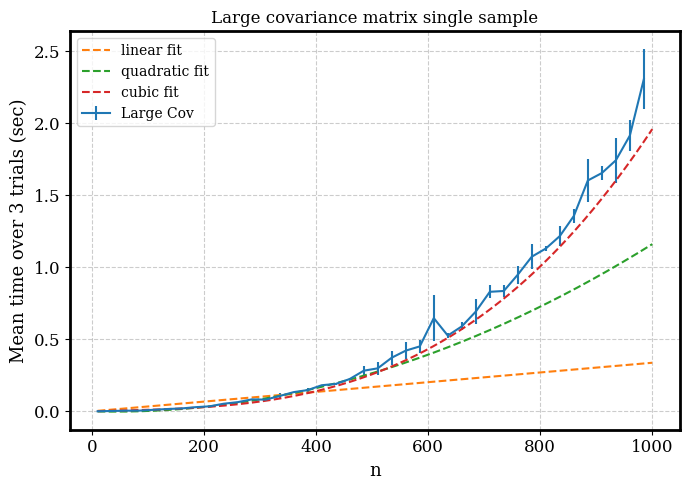

In [24]:
fix,ax=plt.subplots()
ax.errorbar(x=N,y=large_cov_times[:,0],yerr=large_cov_times[:,1],label='Large Cov')
x=np.linspace(10,1000,1000)
ax.plot(x,x*linear_fit_large_cov[0],linestyle='--',label='linear fit')
ax.plot(x,x*quadratic_fit_large_cov[0]+x**2*quadratic_fit_large_cov[1],linestyle='--',label='quadratic fit')
ax.plot(x,x*cubic_fit_large_cov[0]+x**2*cubic_fit_large_cov[1]+x**3*cubic_fit_large_cov[2],linestyle='--',label='cubic fit')
ax.set_xlabel('n')
ax.set_ylabel('Mean time over 3 trials (sec)')
ax.set_title('Large covariance matrix single sample')
ax.legend()
plt.tight_layout()

This scales poorly with n. Infact it scales as $O(n^3)$ as you can see in the fit. Why does this scale that way? To find out we need to investigate how to draw from this kind of distribution.

### How numpy draws from a multivariate normal
Drawing directly from the disrtibution is difficult, but drawing from a standard normal is easy and can be done quickly. So numpy translates the problem into drawing from many standard normals. To see how this works lets look at a nultivariate normal distribution in vector form.

$$
N(\vec0,\sigma)=A\exp{\left(-\frac{1}{2}\vec x^T\sigma^{-1} \vec x\right)}
$$
in this form we have all of the nasty covariance in $\sigma$. If $\sigma$ was diagnal then we could just draw from a bunch of 1d normals to get our sample. So we diagonalize $\sigma$!

$$
\sigma=BDB^{-1}
$$
so we rewrite

$$
N(\vec0,\sigma)=A\exp{\left(-\frac{1}{2}\vec x^TBDB^{-1}\vec x\right)}=A\exp{\left(-\frac{1}{2}\vec y^TD\vec y\right)}
$$
where $\vec{y}$ is $\vec{x}$ transformed by $B$. Now our problem is fast and easy with our coordinate transform $B$. Unfortunatly finding $B$ and other similar methods scale as $O(n^3)$ like we saw above.

## What can we do?
Our matix has structure so we can use some pen and paper to reduce the problem ourselves! We can note that there are only pairs of dimensions that have non-zero covarance, namely dimensions $i$ and $i+n$ for all $i$. This means we can reduce the problem to drawing from $n$ 2d normals since there are $n$ independant coordinate pairs. Splitting this up into many independant draws also makes it easier to use multiprocessing! I've writtten this in code with multiprocessing in utils.py (im pretty sure this is legal, a stats person should double check me here) 

In [28]:
from utils import small_cov_nvm
small_cov_times=[]
for n in N:
    setup=f'a,b,c=rng.uniform(.1,10,{n}),rng.uniform(.1,10,{n}),rng.uniform(.1,10,{n})'
    t=timeit.Timer('small_cov_nvm(a,b,c)',globals=globals(),setup=setup).repeat(3,1)
    small_cov_times.append([np.mean(t),np.std(t)])
small_cov_times=np.array(small_cov_times)

In [ ]:
cubic_fit_small_cov=curve_fit(cube,N,small_cov_times[:,0],sigma=small_cov_times[:,1])[0]
linear_fit_small_cov=curve_fit(lin,N,small_cov_times[:,0],sigma=small_cov_times[:,1])[0]
quadratic_fit_small_cov=curve_fit(quad,N,small_cov_times[:,0],sigma=small_cov_times[:,1])[0]

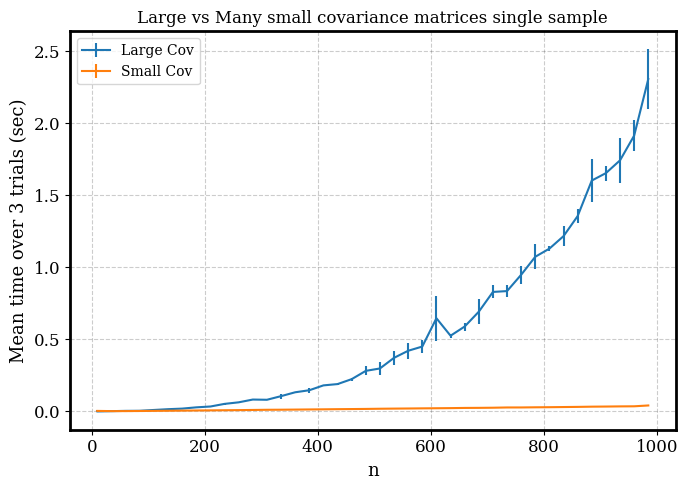

In [30]:
fix,ax=plt.subplots()
ax.errorbar(x=N,y=large_cov_times[:,0],yerr=large_cov_times[:,1],label='Large Cov')
ax.errorbar(x=N,y=small_cov_times[:,0],yerr=small_cov_times[:,1],label='Small Cov')
x=np.linspace(10,1000,1000)
#ax.plot(x,x*linear_fit_large_cov[0],linestyle='--',label='linear fit')
#ax.plot(x,x*quadratic_fit_large_cov[0]+x**2*quadratic_fit_large_cov[1],linestyle='--',label='quadratic fit')
#ax.plot(x,x*cubic_fit_large_cov[0]+x**2*cubic_fit_large_cov[1]+x**3*cubic_fit_large_cov[2],linestyle='--',label='cubic fit')
ax.set_xlabel('n')
ax.set_ylabel('Mean time over 3 trials (sec)')
ax.set_title('Large vs Many small covariance matrices single sample')
ax.legend()
plt.tight_layout()

## WOW! its not even fair to show these on the same plot!
lets also test over a larger range

In [ ]:
small_cov_times=[]
N_fast=np.arange(10,10000,100)
for n in N_fast:
    setup=f'a,b,c=rng.uniform(.1,10,{n}),rng.uniform(.1,10,{n}),rng.uniform(.1,10,{n})'
    t=timeit.Timer('small_cov_nvm(a,b,c)',globals=globals(),setup=setup).repeat(3,1)
    small_cov_times.append([np.mean(t),np.std(t)])
small_cov_times=np.array(small_cov_times)
cubic_fit_small_cov=curve_fit(cube,N_fast,small_cov_times[:,0],sigma=small_cov_times[:,1])[0]
linear_fit_small_cov=curve_fit(lin,N_fast,small_cov_times[:,0],sigma=small_cov_times[:,1])[0]
quadratic_fit_small_cov=curve_fit(quad,N_fast,small_cov_times[:,0],sigma=small_cov_times[:,1])[0]

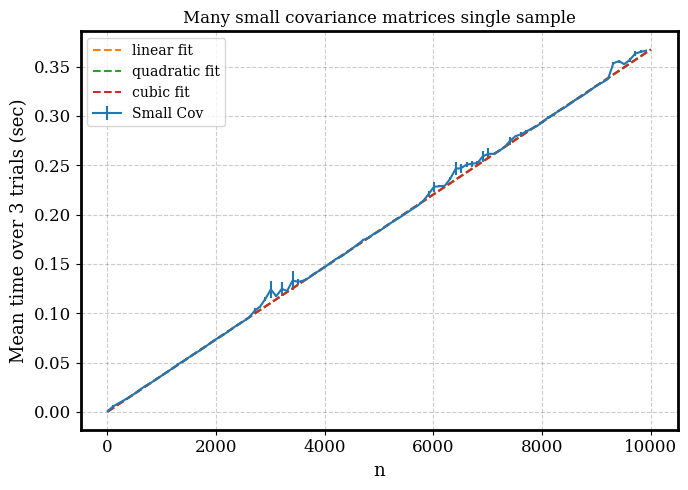

In [37]:
fix,ax=plt.subplots()
#ax.errorbar(x=N,y=large_cov_times[:,0],yerr=large_cov_times[:,1],label='Large Cov')
ax.errorbar(x=N_fast,y=small_cov_times[:,0],yerr=small_cov_times[:,1],label='Small Cov')
x=np.linspace(10,10000,len(N_fast))
ax.plot(x,x*linear_fit_small_cov[0],linestyle='--',label='linear fit')
ax.plot(x,x*quadratic_fit_small_cov[0]+x**2*quadratic_fit_small_cov[1],linestyle='--',label='quadratic fit')
ax.plot(x,x*cubic_fit_small_cov[0]+x**2*cubic_fit_small_cov[1]+x**3*cubic_fit_small_cov[2],linestyle='--',label='cubic fit')
ax.set_xlabel('n')
ax.set_ylabel('Mean time over 3 trials (sec)')
ax.set_title('Many small covariance matrices single sample')
ax.legend()
plt.tight_layout()

Clearly this scales as $O(n)$ which is a massive improvement. This makes sense now what we are doing is doing $n$ draws from a 2d normal, since 2 is a small number we only have a small practically constant time operation $O(1)$ thus our final time is $O(n\cdot 1)$

## When to use Multi-processing
Multi-processing doesnt always win. Ill show this by testing this function out on very large values of n doing multipledraws

In [ ]:
single_t=[]
dual_t=[]
quad_t=[]
x=np.array([100,500,1000,5000,10000,50000,100000,500000]).astype(int)
for i in x:
    setup=f'a,b,c=rng.uniform(.1,10,{i}),rng.uniform(.1,10,{i}),rng.uniform(.1,10,{i})'
    tsingle=timeit.Timer(f'small_cov_nvm(a,b,c,ndraws={1000},ncores=1)',setup=setup,globals=globals()).repeat(3,1)
    tdual=timeit.Timer(f'small_cov_nvm(a,b,c,method="eigh",ndraws={1000},ncores=2)',setup=setup,globals=globals()).repeat(3,1)
    tquad=timeit.Timer(f'small_cov_nvm(a,b,c,method="eigh",ndraws={1000},ncores=4)',setup=setup,globals=globals()).repeat(3,1)
    #tcholesky=timeit.Timer('low_dim(a,b,c,method="cholesky")',setup=setup).repeat(10,1)
    single_t.append([i,np.mean(tsingle),np.std(tsingle)])
    dual_t.append([i,np.mean(tdual),np.std(tdual)])
    quad_t.append([i,np.mean(tquad),np.std(tquad)])
single_t=np.array(single_t)
dual_t=np.array(dual_t)
quad_t=np.array(quad_t)

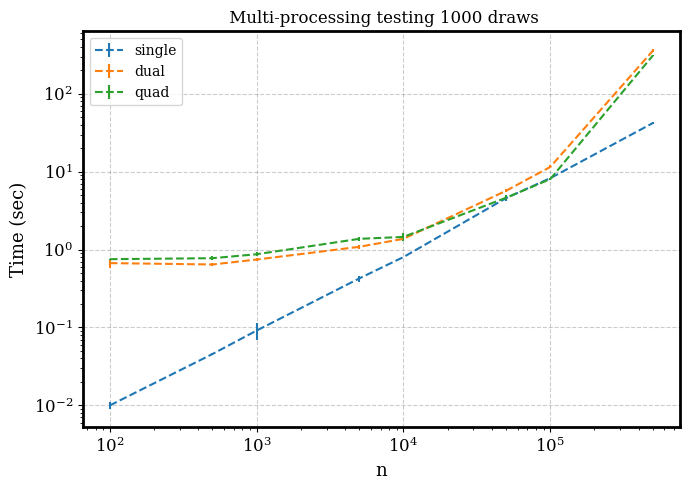

In [55]:
fig,ax=plt.subplots()
ax.errorbar(x=single_t[:,0],y=single_t[:,1],yerr=single_t[:,2],linestyle='--',label="single")
ax.errorbar(x=dual_t[:,0],y=dual_t[:,1],yerr=dual_t[:,2],linestyle='--',label="dual")
ax.errorbar(x=quad_t[:,0],y=quad_t[:,1],yerr=quad_t[:,2],linestyle='--',label="quad")
ax.legend()
ax.set_xlabel('n')
ax.set_ylabel('Time (sec)')
ax.set_title(' Multi-processing testing 1000 draws')
ax.set_xscale('log')
ax.set_yscale('log')
plt.tight_layout()

We can see that multi-processing only starts to be worth it after $n$~$10^5$. Doing tests like this can save you cpu time in the long run!